In [ ]:
# code from: https://github.com/shinnew99/xai-nlp-notebooks/tree/master
# dataset from: https://github.com/shinnew99/korean_unsmile_dataset

# others referenced: https://github.com/jason9693/APEACH

In [ ]:
# ! git clone https://github.com/smilegate-ai/korean_unsmile_dataset

In [1]:
!pip install transformers
!pip install pyarrow
!pip install nlp
!pip install captum
!pip install datasets --upgrade

In [2]:
from typing import Dict

import matplotlib.pyplot as plt
import nlp
import numpy as np
import pandas as pd
import torch
import transformers
from captum.attr import (IntegratedGradients, LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer)
from captum.attr import visualization as viz
from torch.utils.data import Dataset
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics)

transformers.__version__

'4.28.0'

------ Dataset from https://github.com/smilegate-ai/korean_unsmile_dataset -------

In [3]:
from datasets import load_dataset
datasets = load_dataset('smilegate-ai/kor_unsmile')

print(datasets)

# Look at the labels
# print("Training set labels: {}".format(datasets["train"]))
# print("Validation set labels: {}".format(datasets["valid"]))
# print("Test set labels: {}".format(datasets["test"]))

DatasetDict({
    train: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 15005
    })
    valid: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭', 'labels'],
        num_rows: 3737
    })
})


In [4]:
# Explore the dataset
train_df = pd.DataFrame({"sentence": datasets["train"]['문장'],
                   "label": datasets["train"]['labels']})
pd.options.display.max_colwidth = 0
train_df.head()

,sentence,label
0,일안하는 시간은 쉬고싶어서 그런게 아닐까,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. 10 16까지 IQ 떨어지고 출산 위험은 400% 다.,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
2,"루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o doin 진짜 띵곡임 꼭 들어보셈""","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽에서 고소 가능하냐?,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
4,아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런다! 이렇게 2개로 싸우냐.. 내가 볼 땐 둘다 나쁜 말 그 이상도 이하도 아닌데,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [5]:
from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer
model_name = 'smilegate-ai/kor_unsmile'

model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = TextClassificationPipeline(
    model = model,
    tokenizer = tokenizer,
    device = 0,   # cpu: -1, gpu: gpu number
    return_all_scores = True,
    function_to_apply = 'softmax'  # sigmoid
)

for result in pipe("이래서 여자는 게임을 하면 안된다")[0]:
    print(result)
    
    
# {'label': '여성/가족', 'score': 0.8253053426742554}
# {'label': '남성', 'score': 0.039725180715322495}
# {'label': '성소수자', 'score': 0.012144332751631737}
# {'label': '인종/국적', 'score': 0.023181889206171036}
# {'label': '연령', 'score': 0.010315303690731525}
# {'label': '지역', 'score': 0.018454890698194504}
# {'label': '종교', 'score': 0.011270025745034218}
# {'label': '기타 혐오', 'score': 0.0207340307533741}
# {'label': '악플/욕설', 'score': 0.057331427931785583}
# {'label': 'clean', 'score': 0.1401052623987198}

/opt/conda/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


{'label': '여성/가족', 'score': 0.9286561012268066}
{'label': '남성', 'score': 0.008131870068609715}
{'label': '성소수자', 'score': 0.0024165743961930275}
{'label': '인종/국적', 'score': 0.004665035288780928}
{'label': '연령', 'score': 0.002048827474936843}
{'label': '지역', 'score': 0.003695908235386014}
{'label': '종교', 'score': 0.0022406154312193394}
{'label': '기타 혐오', 'score': 0.004162008874118328}
{'label': '악플/욕설', 'score': 0.01195511594414711}
{'label': 'clean', 'score': 0.0320279560983181}


-----------------------------------------------------

In [8]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True)   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
            token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])

In [9]:
train_dataset = TrainerDataset(datasets["train"]["문장"],
                               datasets["train"]["labels"], tokenizer)
eval_dataset = TrainerDataset(datasets["valid"]["문장"],
                              datasets["valid"]["labels"], tokenizer)

In [10]:
# Set seed for reproducibility
np.random.seed(123)
torch.manual_seed(123)

training_args = TrainingArguments(
    output_dir="./models/model_electra",
    num_train_epochs=3,  # 1 (1 epoch gives slightly lower accuracy)
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
#     evaluate_during_training=True,     
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)


def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)


# Instantiate the Trainer class
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics)

In [11]:
trainer.train()

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,0.106300
1000,0.054800


TrainOutput(global_step=1404, training_loss=0.06613543434360428, metrics={'train_runtime': 964.7136, 'train_samples_per_second': 46.662, 'train_steps_per_second': 1.455, 'total_flos': 2655310151370240.0, 'train_loss': 0.06613543434360428, 'epoch': 3.0})

In [10]:
# model_result = trainer.evaluate()
# print("Accuracy: {}".format(model_result["eval_acc"]))

In [12]:
text = "개슬람녀 다 필요없고 니 엄마만 있으면 된다"
# true_label = 1

[x for x in datasets["valid"] if x["문장"] == text]

[{'문장': '개슬람녀 다 필요없고 니 엄마만 있으면 된다',
  '여성/가족': 0,
  '남성': 0,
  '성소수자': 0,
  '인종/국적': 1,
  '연령': 0,
  '지역': 0,
  '종교': 1,
  '기타 혐오': 0,
  '악플/욕설': 0,
  'clean': 0,
  '개인지칭': 0,
  'labels': [0, 0, 0, 1, 0, 0, 1, 0, 0, 0]}]

In [13]:
from transformers import BertForSequenceClassification, AutoTokenizer

model_name = 'smilegate-ai/kor_unsmile'

# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Assuming you saved the model using model.save_pretrained
# Load the model from the saved directory
loaded_model = BertForSequenceClassification.from_pretrained('./models/model_electra/checkpoint-1000')

# Now you can create a TextClassificationPipeline with the loaded model
pipe = TextClassificationPipeline(
    model=loaded_model,
    tokenizer=tokenizer,
    device=0,  # Adjust the device as needed (cpu: -1, gpu: gpu number)
    return_all_scores=True,
    function_to_apply='softmax'  # Change to 'sigmoid' if needed
)

# Example input text for inference
input_text = "한글 문장을 입력하여 감정을 분류해 봅시다."

# Perform inference
result = pipe(input_text)

# Print or use the result as needed
print(result)

[[{'label': '여성/가족', 'score': 7.276040560100228e-05}, {'label': '남성', 'score': 4.6614462917204946e-05}, {'label': '성소수자', 'score': 5.4869560699444264e-05}, {'label': '인종/국적', 'score': 8.571979560656473e-05}, {'label': '연령', 'score': 3.5505527193890885e-05}, {'label': '지역', 'score': 3.747600203496404e-05}, {'label': '종교', 'score': 3.799369733314961e-05}, {'label': '기타 혐오', 'score': 5.222225809120573e-05}, {'label': '악플/욕설', 'score': 0.0001366801152471453}, {'label': 'clean', 'score': 0.9994401335716248}]]


/opt/conda/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [14]:
input_text = "그게 표준하긴 한데 한국말이 좋같이 들리잖아요."  # 좆

# Perform inference
result = pipe(input_text)


dict_result = { x['label']:x['score'] for x in result[0]}
sorted(dict_result.items(), key=lambda x : x[1],reverse=True)

[('clean', 0.9991135001182556),
 ('인종/국적', 0.00023709837114438415),
 ('악플/욕설', 0.00020941825641784817),
 ('여성/가족', 9.385998419020325e-05),
 ('기타 혐오', 7.636332156835124e-05),
 ('종교', 7.301344157895073e-05),
 ('지역', 5.159412830835208e-05),
 ('연령', 5.0527931307442486e-05),
 ('성소수자', 5.016221257392317e-05),
 ('남성', 4.44105826318264e-05)]

In [15]:
input_text2 = "그게 표준하긴 한데 한국말이 좆같이 들리잖아요."

# Perform inference
result = pipe(input_text2)


dict_result2 = { x['label']:x['score'] for x in result[0]}
sorted(dict_result2.items(), key=lambda x : x[1],reverse=True)

[('인종/국적', 0.7605646252632141),
 ('clean', 0.22179283201694489),
 ('악플/욕설', 0.011406375095248222),
 ('기타 혐오', 0.0012511309469118714),
 ('지역', 0.0012311720056459308),
 ('종교', 0.0012061460874974728),
 ('여성/가족', 0.0007989403675310314),
 ('연령', 0.000726620142813772),
 ('남성', 0.0006515356944873929),
 ('성소수자', 0.0003706327988766134)]

수행 순서
1. 욕설 긍부정 모델 학습 - goingdeeper1, 노드1
2. 단어 사전 학습 - goingdeeper3


최종 목표
1. 문장별로 욕인지 아닌지 판별 -1
2. 문장 형태소 분석
3. 욕설과 가까운 단어 유사도 -2 
4 . 1,2 동시 수행

In [6]:
train_df.sentence

0        일안하는 시간은 쉬고싶어서 그런게 아닐까                                                                              
1        아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. 10 16까지 IQ 떨어지고 출산 위험은 400% 다.                        
2        루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o  doin 진짜 띵곡임 꼭 들어보셈"                                            
3        홍팍에도 어버이연합인가 보내요 뭐 이런뎃글 있는데 이거 어버이연합측에 신고하면 그쪽에서 고소 가능하냐?                                           
4        아놔 왜 여기 댓들은 다 여자들이 김치녀라고 먼저 불렸다! 여자들은 더 심하게 그런다! 이렇게 2개로 싸우냐.. 내가 볼 땐 둘다 나쁜 말 그 이상도 이하도 아닌데         
                                                    ...                                                      
15000    께롱께롱께롱!!!                                                                                           
15001    갱상도가아니라 홍어지 개좃같은 홍어년들                                                                               
15002    말레이시아랑 인도네시아 여자 존나 못생겼던데                                                                            
15003    링

In [7]:
train_df.label

0        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
1        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
2        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
3        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
4        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
                      ...              
15000    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
15001    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
15002    [1, 0, 0, 1, 0, 0, 0, 0, 0, 0]
15003    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
15004    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Name: label, Length: 15005, dtype: object

Data Size: 15004
문장의 최단 길이: 3
문장의 최장 길이: 155
문장의 평균 길이: 39


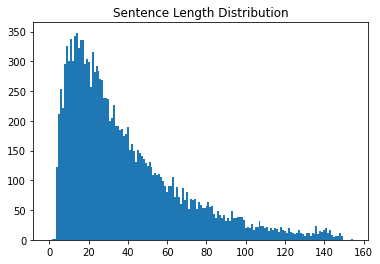

In [7]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_df.sentence))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

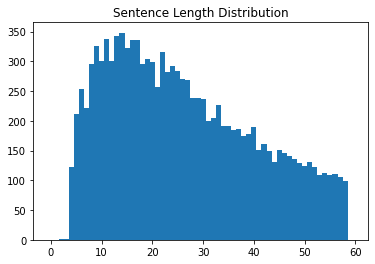

In [8]:
max_len = 60
min_len = 0

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

filtered_corpus = [] 
filtered_label = []  
for s, label in zip(train_df['sentence'], train_df['label']):    
    if (len(s) < max_len):     
        filtered_corpus.append(s)  
        filtered_label.append(label) 
        
# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()